<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/xor_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Using Graph Neural Networks
By Fayyaz Minhas.


This tutorial demonstrates how to model the XOR problem as a graph classification task using PyTorch Geometric. Each graph represents two binary inputs as nodes and the edges between them represent the input configuration. The goal is to classify the graphs according to the XOR operation:

* Input graph with nodes 0 and 1 and an edge connecting 0 to 0 -> Output: 0
* Input graph with nodes 0 and 1 and an edge connecting 0 to 1 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 0 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 1 -> Output: 0

### Graph Attention Networks (GAT)
Graph Attention Networks (GAT) extend the Graph Convolutional Network (GCN) by incorporating an attention mechanism. This mechanism allows the network to weigh the importance of neighboring nodes differently, thus enabling the model to focus on the most relevant parts of the graph. GATConv layers compute the attention coefficients between nodes and use them to aggregate neighbor features.

Below is the complete implementation, starting from data preparation, defining the model, training, evaluation, and visualization.



In [ ]:
!pip install torch-geometric

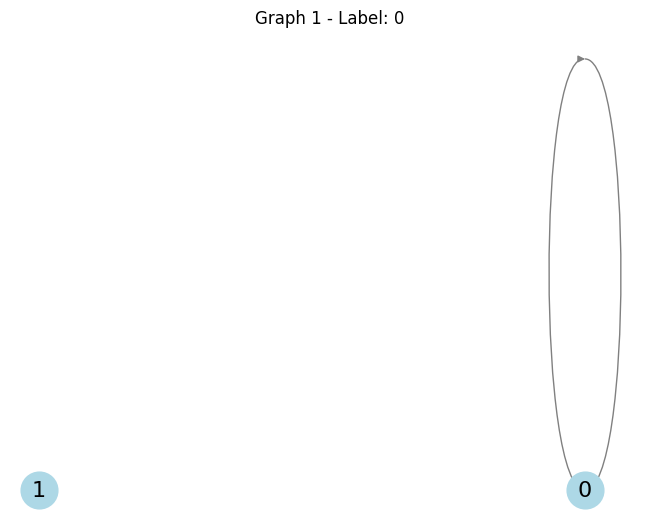

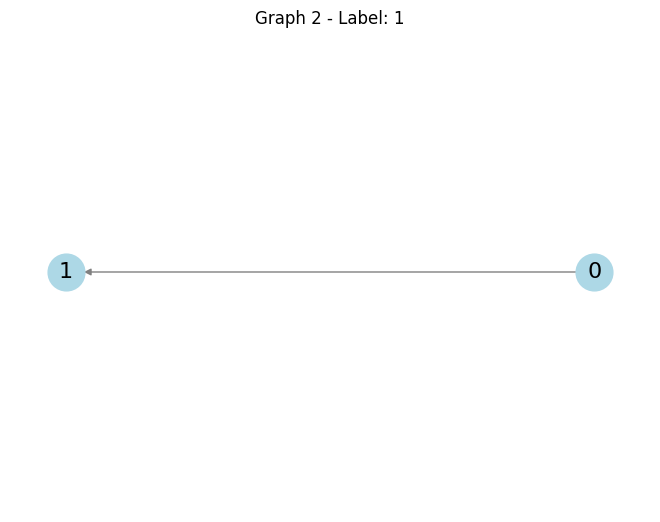

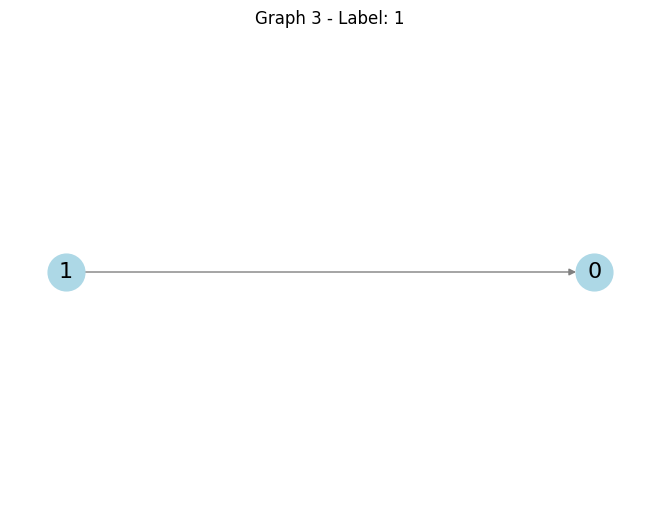

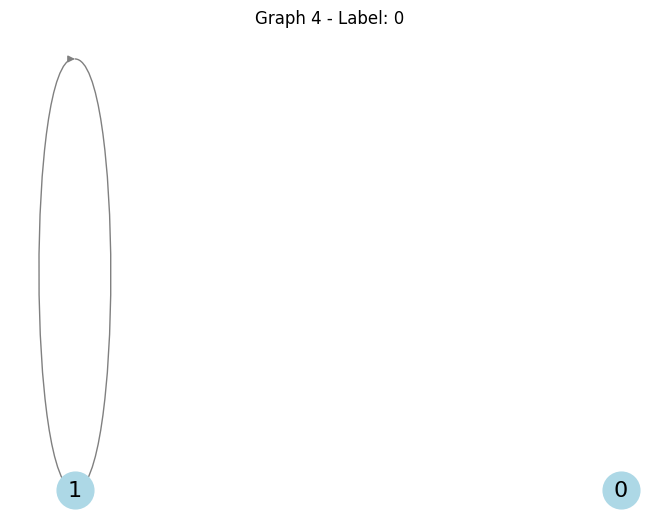

Epoch: 000, Loss: 0.7296
Epoch: 010, Loss: 0.7206
Epoch: 020, Loss: 0.6937
Epoch: 030, Loss: 0.6144
Epoch: 040, Loss: 0.6328
Epoch: 050, Loss: 0.4936
Epoch: 060, Loss: 0.2137
Epoch: 070, Loss: 0.0340
Epoch: 080, Loss: 0.0124
Epoch: 090, Loss: 0.0002
Epoch: 100, Loss: 0.0001
Epoch: 110, Loss: 0.0033
Epoch: 120, Loss: 0.0024
Epoch: 130, Loss: 0.0000
Epoch: 140, Loss: 0.0000
Epoch: 150, Loss: 0.0009
Epoch: 160, Loss: 0.0011
Epoch: 170, Loss: 0.0009
Epoch: 180, Loss: 0.0000
Epoch: 190, Loss: 0.0007
Epoch: 200, Loss: 0.0006
Epoch: 210, Loss: 0.0000
Epoch: 220, Loss: 0.0003
Epoch: 230, Loss: 0.0003
Epoch: 240, Loss: 0.0004
Epoch: 250, Loss: 0.0003
Epoch: 260, Loss: 0.0003
Epoch: 270, Loss: 0.0000
Epoch: 280, Loss: 0.0000
Epoch: 290, Loss: 0.0002
Epoch: 300, Loss: 0.0002
Epoch: 310, Loss: 0.0002
Epoch: 320, Loss: 0.0002
Epoch: 330, Loss: 0.0001
Epoch: 340, Loss: 0.0002
Epoch: 350, Loss: 0.0001
Epoch: 360, Loss: 0.0001
Epoch: 370, Loss: 0.0000
Epoch: 380, Loss: 0.0001
Epoch: 390, Loss: 0.0001


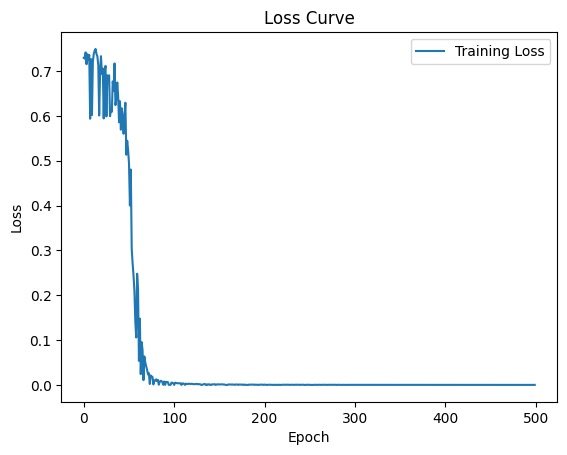

Accuracy: 1.0000
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 1
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Define the XOR dataset
class XORGraphDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.graphs = []
        self.labels = []

        # Add the four graphs and their labels
        self.add_graph([0, 1], [[0, 0]], 0)
        self.add_graph([0, 1], [[0, 1]], 1)
        self.add_graph([0, 1], [[1, 0]], 1)
        self.add_graph([0, 1], [[1, 1]], 0)

    def add_graph(self, nodes, edges, label):
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        self.graphs.append(data)
        self.labels.append(label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


# Visualize graphs using NetworkX with directed edges and a compact layout
def showGraph(dataset):
  for i, graph in enumerate(dataset):
      G = to_networkx(graph, to_undirected=False)
      pos = nx.circular_layout(G)
      plt.figure()
      nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=16, arrows=True)
      plt.title(f'Graph {i+1} - Label: {graph.y.item()}')
      plt.show()
# Prepare the dataset and data loader
dataset = XORGraphDataset()
showGraph(dataset)

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1, 4, heads=2)
        self.conv2 = GATConv(8, 4, heads=2)
        self.fc = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')
# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')



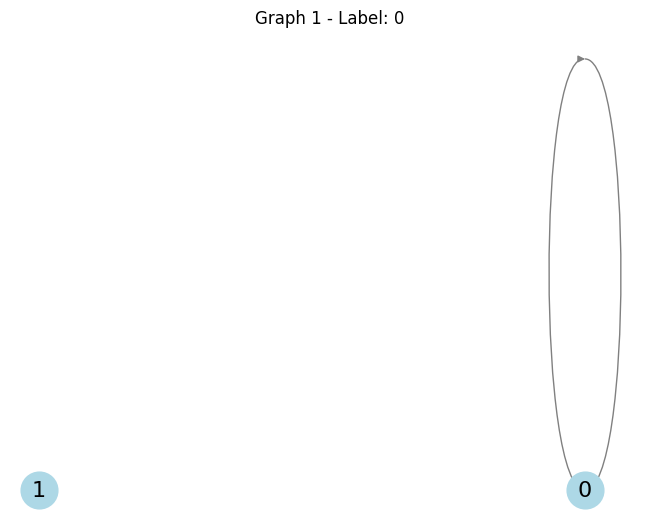

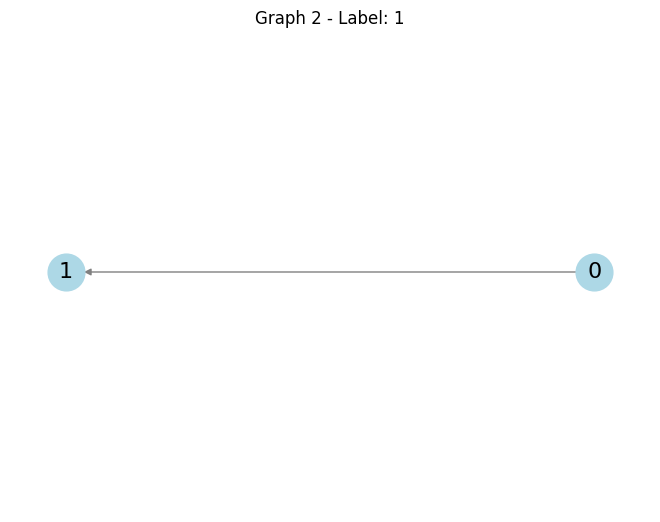

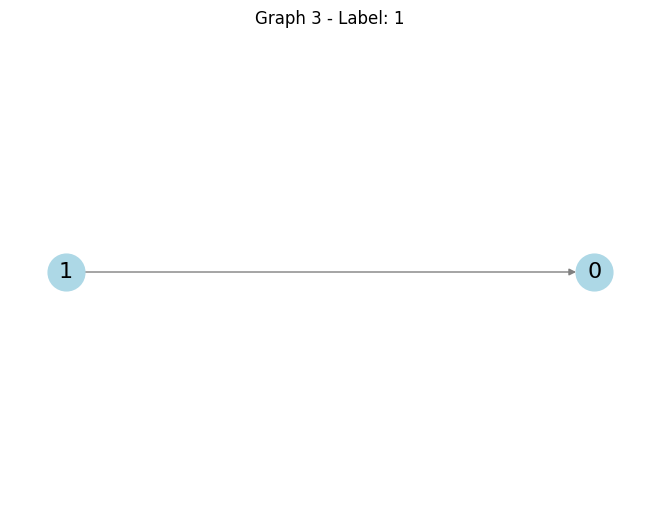

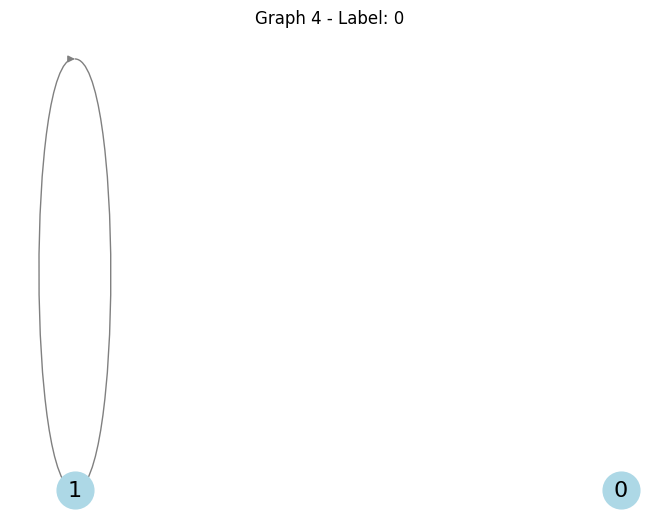

Epoch: 000, Loss: 0.8109
Epoch: 010, Loss: 0.6918
Epoch: 020, Loss: 0.5085
Epoch: 030, Loss: 0.0001
Epoch: 040, Loss: 0.0000
Epoch: 050, Loss: 0.0004
Epoch: 060, Loss: 0.0000
Epoch: 070, Loss: 0.0000
Epoch: 080, Loss: 0.0000
Epoch: 090, Loss: 0.0000
Epoch: 100, Loss: 0.0002
Epoch: 110, Loss: 0.0000
Epoch: 120, Loss: 0.0000
Epoch: 130, Loss: 0.0000
Epoch: 140, Loss: 0.0000
Epoch: 150, Loss: 0.0001
Epoch: 160, Loss: 0.0000
Epoch: 170, Loss: 0.0000
Epoch: 180, Loss: 0.0000
Epoch: 190, Loss: 0.0000
Epoch: 200, Loss: 0.0000
Epoch: 210, Loss: 0.0000
Epoch: 220, Loss: 0.0000
Epoch: 230, Loss: 0.0000
Epoch: 240, Loss: 0.0000
Epoch: 250, Loss: 0.0000
Epoch: 260, Loss: 0.0000
Epoch: 270, Loss: 0.0000
Epoch: 280, Loss: 0.0000
Epoch: 290, Loss: 0.0000
Epoch: 300, Loss: 0.0000
Epoch: 310, Loss: 0.0000
Epoch: 320, Loss: 0.0000
Epoch: 330, Loss: 0.0000
Epoch: 340, Loss: 0.0000
Epoch: 350, Loss: 0.0000
Epoch: 360, Loss: 0.0000
Epoch: 370, Loss: 0.0000
Epoch: 380, Loss: 0.0000
Epoch: 390, Loss: 0.0000


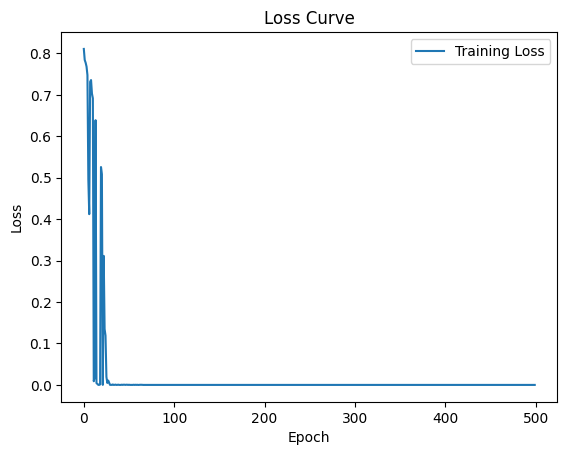

Accuracy: 1.0000
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 1
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [30]:
!pip install torch-geometric

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import EdgeConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Define the XOR dataset
class XORGraphDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.graphs = []
        self.labels = []

        # Add the four graphs and their labels
        self.add_graph([0, 1], [[0, 0]], 0)
        self.add_graph([0, 1], [[0, 1]], 1)
        self.add_graph([0, 1], [[1, 0]], 1)
        self.add_graph([0, 1], [[1, 1]], 0)

    def add_graph(self, nodes, edges, label):
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        self.graphs.append(data)
        self.labels.append(label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# Visualize graphs using NetworkX with directed edges and a compact layout
def showGraph(dataset):
    for i, graph in enumerate(dataset):
        G = to_networkx(graph, to_undirected=False)
        pos = nx.circular_layout(G)
        plt.figure()
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=16, arrows=True)
        plt.title(f'Graph {i+1} - Label: {graph.y.item()}')
        plt.show()

# Prepare the dataset and data loader
dataset = XORGraphDataset()
showGraph(dataset)

# Define the EdgeConv model
class EdgeNet(torch.nn.Module):
    def __init__(self):
        super(EdgeNet, self).__init__()
        self.conv1 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(2, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.conv2 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(8, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.fc = torch.nn.Linear(4, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')
